# Hawai'i Island Hotels and Resorts: TripAdvisor Review NLP

Visitor reviews of vacation lodging are an important source of information for hotel and resort management. A traditional approach to gathering this data would be via surveys, comment cards, or even phone transcriptions to customer service call centers. A modern approach to gleaning insights from visitors can be accomplished via natural language processing (NLP) of reviews left on websites such as TripAdvisor. 

With this approach, visitors are in an environment where they can openly share their opinions in a natural way without the interference of a researcher. They are allowed to freely express their opinions in their own words without prompting as done in a survey. Biases usually introduced by the subjectivity of a researcher are all but eliminated, however it should be noted that visitors' reviews could be influenced by reading other reviews prior to writing their own. Also, considerations should be made that visitors providing reviews to websites like TripAdvisor are self-selecting so an argument about how representative the sample is could be made.

Nevertheless, I believe the positives outweigh the negatives and that meaningful, if not actionable, insights can be extracted from visitor hotel reviews. The goal of this study will be:

* Determine words and phrases commonly found in positive/negative reviews (i.e. "front desk","check in","room service","pool",etc.)
* Understand how (and if) time impacts reviews either longitudinally or seasonally

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from textblob import Word
from textblob.utils import strip_punc
from textblob.wordnet import ADJ
from nltk.corpus import stopwords
from nltk.corpus import wordnet
%matplotlib inline

TripAdvisor offers and [API](https://developer-tripadvisor.com/content-api/) but does not allow the API to be called for gathering hotel reviews for research purposes. This means one needs to resort to web scraping in order to gather reviews and metadata relating to them.

While a number of web scraping tools exist such as [Octoparse](http://www.octoparse.com/) I chose to stay within the Python environment for all stages of this project. Python also has a number of web scraping packages. I chose Scrapy due to its relatively easy to understand coding structure.

Scrapy has an extensive number of features for production-level web scraping but for this research only a base scraper was needed.

In [2]:
import scrapy
from tripadvisor.items import TripadvisorItem

class TrSpider(scrapy.Spider):
    name = 'trspider'
    start_urls = [
            'https://www.tripadvisor.com/Hotels-g29217-Island_of_Hawaii_Hawaii-Hotels.html'
            ]

    def parse(self, response):
        for href in response.xpath('//div[@class="listing_title"]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_hotel)

        next_page = response.xpath('//div[@class="unified pagination standard_pagination"]/child::*[2][self::a]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse)

    def parse_hotel(self, response):
        for href in response.xpath('//div[starts-with(@class,"quote")]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_review)


        next_page = response.xpath('//link[@rel="next"]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse_hotel)

    def parse_review(self, response):
        item = TripadvisorItem()
        item['headline'] = response.xpath('translate(//div[@class="quote"]/text(),"!"," ")').extract()[0][1:-1]
        item['review'] = response.xpath('translate(//div[@class="entry"]/p,"\n"," ")').extract()[0]
        item['bubbles'] = response.xpath('//span[contains(@class,"ui_bubble_rating")]/@alt').extract()[0]
        item['date'] = response.xpath('normalize-space(//span[contains(@class,"ratingDate")]/@content)').extract()[0]
        item['hotel'] = response.xpath('normalize-space(//span[@class="altHeadInline"]/a/text())').extract()[0]
        return item

ModuleNotFoundError: No module named 'tripadvisor'

Most of the above code was reworked from that found [here](https://github.com/monkeylearn/hotel-review-analysis) from the team at MonkeyLearn. At the time of writing, the original code no longer appeared to work due apparent changes in TripAdvisor's webpage design and had to be tweaked in order to run correctly.

The web scraper (or "spider") begins with a base URL. In this case I started at the main page for Island of Hawai'i hotels. The Python class "TrSpider" contains three functions for parsing reviews and following links to navigate multiple pages of reviews. Ultimately, the scraper creates a CSV file containing the following features:

* Review headline
* Review text
* Bubble rating
* Review date
* Hotel/Resort name

In [12]:
df = pd.read_csv('bihotels.csv', dtype={'bubbles':'category','hotel':'category','review':'str'}, parse_dates=[1])
df.dropna(inplace=True)
df['rating'] = np.where((df['bubbles'] == '5 of 5 bubbles') | (df['bubbles'] == '4 of 5 bubbles'), 'pos', 'neg')
df = df.groupby('hotel').filter(lambda x: len(x) > 100)
df['hotel'] = df['hotel'].cat.remove_unused_categories()
df.head()

,bubbles,date,headline,hotel,review,rating
0,5 of 5 bubbles,2017-07-19,Satisfied Beyond our expectations,"Fairmont Orchid, Hawaii",From the moment we arrived at the Fairmont or...,pos
1,5 of 5 bubbles,2017-07-19,Honeymoon at the Fairmont,"Fairmont Orchid, Hawaii",We went there for our honeymoon and were wowe...,pos
2,3 of 5 bubbles,2017-07-19,Travelguy,"Fairmont Orchid, Hawaii",Hotel is in a lovely remote location and is a...,neg
3,4 of 5 bubbles,2017-06-29,Met our expectations,Wyndham Mauna Loa Village,"We stayed here for 7 nights, June 18-25, 2017...",pos
4,5 of 5 bubbles,2017-06-27,Great hotel with amazing views,"Fairmont Orchid, Hawaii",My husband and I stayed here at the beginning...,pos


Some general data clensing is performed to remove records with missing values and dropping hotels with fewer than 100 reviews. This leaves us with 40,806 reviews to work with from over 14 years (4/6/2003 - 7/20/2017).

Additional, I created a feature, "rating," combining 4 and 5 bubble reviews (positive) and 1, 2, and 3 bubble reviews (negative) intended to simplify the definition of "positive review" from "negative review." 

If we were building a classification model for determining what words/n-grams/etc. best differentiated between positive and negative reviews we'd have an issue of imbalance since most reviews for Hawai'i Island hotels are "positive" (good job!). 

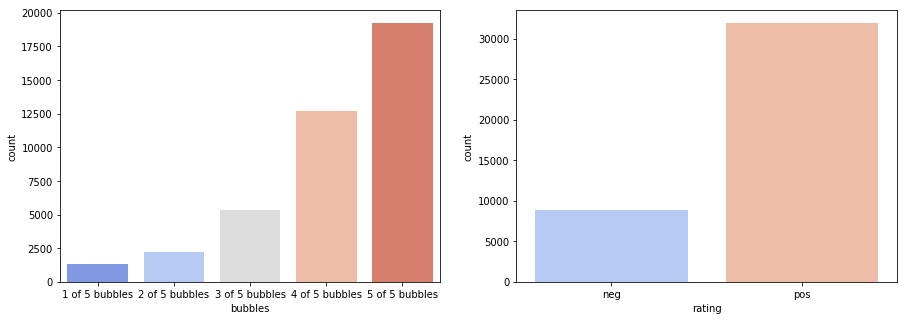

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
sns.countplot(df['bubbles'], ax=axs[0], palette='coolwarm')
sns.countplot(df['rating'], ax=axs[1], palette='coolwarm', order=['neg','pos'])

Sentiment analysis is typically performed in unsupervised learning applications (i.e. those where we do not have labels/target variables to differentiate between classes). Just for fun, I wanted to see how well TextBlob's built-in analyzer worked. While there really isn't a "right" answer here, we can use a review's bubble score as a comparative metric. After all, you wouldn't write a horrible review/headline and then give a hotel 5 out of 5, would you?

Although the package offers two options, I found the Naive Bayes classifier to take much longer than the default classifier which scores reviews by extracting the adjectives, scoring their sentiment based on a built in lexicon of pre-scored adjectives, and averaging the scores for each review to arrive at a final score between -1 and 1. According to the documentation for the pattern package where this is pulled from, a sentiment score >0.1 is an indication of "positive" (although I'm not certain if this threshold is arbitrary or not).

In [14]:
df['rev_sent'] = df['review'].apply(lambda x: TextBlob(x).sentiment[0])
df['head_sent'] = df['headline'].apply(lambda x: TextBlob(x).sentiment[0])

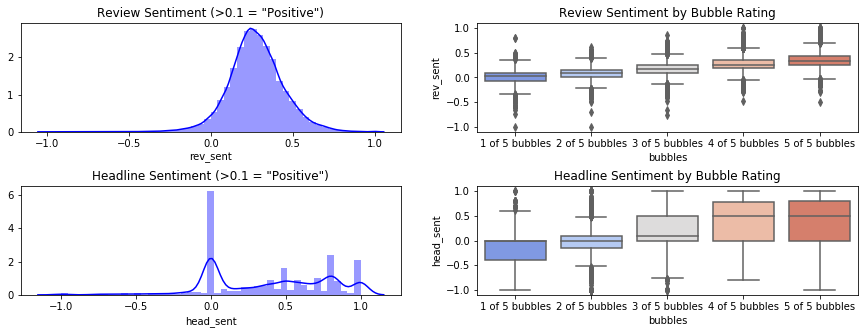

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
plt.subplots_adjust(hspace=.5)
sns.distplot(df['rev_sent'], hist=True, color='blue', ax=axs[0,0])
sns.boxplot(x='bubbles', y='rev_sent', data=df, palette='coolwarm', ax=axs[0,1])
sns.distplot(df['head_sent'], hist=True, color='blue', ax=axs[1,0])
sns.boxplot(x='bubbles', y='head_sent', data=df, palette='coolwarm', ax=axs[1,1])
axs[0,0].set_title('Review Sentiment (>0.1 = "Positive")')
axs[0,1].set_title('Review Sentiment by Bubble Rating')
axs[1,0].set_title('Headline Sentiment (>0.1 = "Positive")')
axs[1,1].set_title('Headline Sentiment by Bubble Rating')

Three things become apparent after applying the sentiment analyzer:

* The pattern package documentation suggests that the default partition between positive and negative sentiment is at 0.1 with higher scores categorized as "positive." The histogram for reviews on the left shows a similar distribution of higher sentiment scores compariable to the abundance of 4 and 5 bubble reviews we saw earlier.
* The analyzer seems to work decently but is far from perfect. While we'd expect to see higher bubble ratings associated with stronger positive sentiment, we also see several outliers among our grouped box plots especially among the 1 bubble reviews.
* Headlines are short and limited in length so several have no adjectives that can be scored. Therefore sentiment scoring is sparse and we aren't really given a good indication (notice the peak at "0.0" on the left-side histogram).

Moving forward, we want to begin exploring what key words and noun phrases are mentioned most frequently in positive and negative reviews. This information is valuable to hotel/resort management since it can help them identify areas that need improvement and areas that they excel in. Also, since we have a timestamp tied to each review we can identify trends if not seasonality in the use of key words in reviews.

In [90]:
stopWords = set(stopwords.words('english'))

In [223]:
test = ' '.join([word for word in df['review'][10].split() if word not in stopWords])

In [226]:
test = TextBlob(df['review'][10]).noun_phrases

In [227]:
test

WordList(['lovely pool', 'great waterview', 'convenient location', 'clean ... ..and amenities', 'manyothers lack', 'guest use', 'century ... ...', 'guest internet'])

In [32]:
def phraser(string):
    strip = strip_punc(string, all=True)
    text = TextBlob(strip)
    return text.noun_phrases
df['noun_phrases'] = df['review'].apply(lambda x: phraser(x))